<a href="https://colab.research.google.com/github/maxiperezc/memoscopio/blob/master/HPC/cargaslibresGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargas Electricas Libres en 2D

Tiempo Total:  190.529 [ms]
Tiempo bucle:  190.365 [ms]


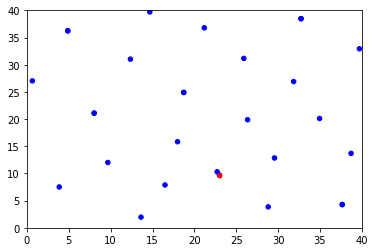

In [89]:
import numpy
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from datetime import datetime

tiempo_total = datetime.now()
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
tiempo_bucle = datetime.now()

positivas = 80
negativas = 1
numpoints = positivas + negativas
colores = ['blue'] * positivas + ['red'] * negativas 

def move():
  x_cpu  = numpy.random.uniform(10.0, 30.0, size=numpoints)
  y_cpu  = numpy.random.uniform(10.0, 30.0, size=numpoints)
  carga  = [1] * positivas + [-1] * negativas 
  vx_cpu = numpy.empty_like( x_cpu )
  vy_cpu = numpy.empty_like( y_cpu )

  while True:
    for i in range( 0, numpoints ):
      vx_cpu[i] = 0
      vy_cpu[i] = 0
      ex = 0
      ey = 0

      for j in range( 0, numpoints ):
        if i != j:
          dx = x_cpu[j] - x_cpu[i]
          dy = y_cpu[j] - y_cpu[i]

          rsq = pow(dx,2) + pow(dy,2)
          rrt = rsq * numpy.sqrt(rsq)

          if rrt > 1:
            ch = carga[i]*carga[j]
            ex -= ch*dx/rrt
            ey -= ch*dy/rrt

      vx_cpu[i] += ex
      vy_cpu[i] += ey

    for i in range( 0, numpoints ):
      x_cpu[i] += vx_cpu[i]
      y_cpu[i] += vy_cpu[i]

    yield numpy.c_[x_cpu, y_cpu]

def update(i):
    data = next(stream)
    scat.set_offsets(data)
    return scat,

fig, ax = plt.subplots()
stream = move()
x, y = next(stream).T
scat = ax.scatter(x, y, c=colores, s=20, vmin=0, vmax=1)
ax.axis([0, 40, 0, 40])

anim = animation.FuncAnimation(fig, update, frames=np.arange(0, 1, 0.005), interval=100, blit=True, repeat=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')

tiempo_bucle = datetime.now() - tiempo_bucle
tiempo_total = datetime.now() - tiempo_total

print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo bucle: ", tiempo_en_ms( tiempo_bucle ), "[ms]" )

anim
